# Análise exploratória e modelo de predição dos dados do Cartola FC

## FGV EPGE - Escola de Pós-graduação em Economia

### Introdução à Ciência dos Dados em Economia com o Python

###### Professor: Rafael Martins de Souza

###### Aluno: Deivid Cezar Silva

### O que é o Cartola FC?

$\hspace{10mm}$ Trata-se de um fantasy game sobre a Série A do Campeonato Brasileiro de futebol. No jogo, é possível, a cada rodada, comprar jogadores da disputa por meio de cartoletas e montar um time. Ao final do turno, com a variação dos preços os jogadores tem o patrimônio alterado para etapa seguinte e somam pontos baseados no desempenho dos jogadores como, por exemplo, gols, assistências e desarmes.

### Motivação

$\hspace{10mm}$ Sabe-se que a maior competição futebolista do país é a Copa do Brasil "hahaha". Dessa forma, enquanto o melhor clube brasileiro, com seis taças da Copa do Brasil, busca atingir um título inédito, a Série B do Campeonato Brasileiro, não há muita coisa interessante para acompanhar na Série A. Buscou-se, com o game, um incentivo para acompanhar essa categoria do futebol brasileiro, além da diversão com os amigos. Nesse contexto, o presente estudo busca responder a seguinte questão: é possível alcançar resultados homogêneos e acima da média com um algoritmo de seleção automática de jogadores?

### Objetivos

$\hspace{10mm}$ Objetivou-se, inicialmente realizar a limpeza dos dados e analisar visualmente o desempenho dos melhores jogadores, bem como, os jogadores que acumulam os maiores scouts. Posteriormente, investigou-se a relação do desempenho dos jogadores com o mando do campo e quais são as posições com as maiores pontuações médias. Por fim, implementou-se um algoritmo de seleção automática de jogadores com o scikit-learn e analisou-se os resultados finais.

### Análise exploratória

$\hspace{10mm}$ Iniciou-se com a importação das bibliotecas necessárias para o trabalho: pandas, altair e sklearn.

In [1]:
# Importando bibliotecas:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Desabilitando máximo de linhas para os data frames trabalhados:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

$\hspace{10mm}$ Em seguida, importou-se os dados separados em csvs, seguindo com a limpeza e concatenação das planilhas.

In [2]:
# Importando tabela com confrontos:
df_jogos = pd.read_excel('Jogos.xlsx')

# Importando dados das rodadas e unindo todos em um único data frame - começando com um Data frame vazio:
df_rodadas = pd.DataFrame()

# Range para todas as rodadas:
for i in range(1,24): 
    
    # Importando csvs
    df = pd.read_csv(f'rodada-{i}.csv')
    
    # Removendo duplicatas e linhas vazias no csv da rodada 10:
    if i == 10:
        df = df.drop_duplicates(subset=['atletas.nome'])
        df = df[df['atletas.rodada_id'] == '10']
        
    # Excluindo colunas que não serão úteis na análise:
    df = df.drop(columns = ['Unnamed: 0','atletas.slug','atletas.foto','atletas.atleta_id','atletas.clube_id','atletas.status_id'])

    # Renomeando colunas:
    df.rename(columns = {'atletas.nome':'Nome completo', 'atletas.apelido':'Jogador','atletas.rodada_id':'Rodada','atletas.posicao_id':'Posição','atletas.pontos_num':'Pontuação','atletas.preco_num':'Preço (C$)','atletas.variacao_num':'Variação (C$)','atletas.media_num':'Média','atletas.jogos_num':'Jogos','atletas.clube.id.full.name':'Clube'}, inplace=True)

    # Aplicando método para letras maiusculas na coluna da posição dos jogadores:
    df['Posição'] = df['Posição'].str.upper()
    
    # Concatenando dados:
    df_rodadas = pd.concat([df_rodadas, df], axis=0, ignore_index = True, sort = False)
    
# Substituindo NaN por zeros:    
df_rodadas = df_rodadas.fillna(0)

# Convertendo os tipos de algumas colunas para float/int:
df_rodadas['Pontuação'] = df_rodadas['Pontuação'].astype(float)
df_rodadas['Variação (C$)'] = df_rodadas['Variação (C$)'].astype(float)
df_rodadas['Rodada'] = df_rodadas['Rodada'].astype(int)

# Corrigindo problemas nos nomes dos clubes:
df_rodadas['Clube'] = df_rodadas['Clube'].replace({'266':'Fluminense', '293':'Athlético-PR', '263':'Botafogo', '290':'Goiás', '265':'Bahia', '285':'Internacional', '264':'Corinthians', '267':'Vasco', '292':'Sport', '284':'Grêmio', '354':'Ceará', '280':'Bragantino', '373':'Atlético-GO', '276':'São Paulo', '275':'Palmeiras', '282':'Atlético-MG', '356':'Fortaleza'})

# Há um erro na rodada 10 - foi contabilizado 30 gols ao invés de 1 gol:
df_rodadas.loc[7038, 'G'] = 1

# O jogador Vina "mudou" de nome ao longo da competição - corrigindo:
for i in df_rodadas[df_rodadas['Nome completo'] == 'Vinícius Goes Barbosa de Souza'].index.tolist():
    df_rodadas.loc[i, 'Jogador'] = 'Vina'

# Apresentação das cinco primeiras linhas:
df_rodadas.head()

,Nome completo,Jogador,Rodada,Posição,Pontuação,Preço (C$),Variação (C$),Média,Jogos,Clube,...,DD,GS,FD,GC,SG,A,I,CV,PP,DP
0,Jorge de Moura Xavier,Jorginho,1,MEI,0.0,6,0.0,0,0,Atlético-GO,...,0,0,0,0,0,0,0,0,0,0
1,Vagner Carmo Mancini,Vagner Mancini,1,TEC,0.0,2,0.0,0,0,Atlético-GO,...,0,0,0,0,0,0,0,0,0,0
2,Moacir Costa da Silva,Moacir,1,MEI,0.0,3,0.0,0,0,Atlético-GO,...,0,0,0,0,0,0,0,0,0,0
3,Leonardo Cittadini,Léo Cittadini,1,MEI,9.8,12.9,4.9,9.8,1,Athlético-PR,...,0,0,0,0,0,0,0,0,0,0
4,Alex Roberto Santana Rafael,Alex Muralha,1,GOL,0.0,5,0.0,0,0,Coritiba,...,0,0,0,0,0,0,0,0,0,0


$\hspace{10mm}$ O primeiro gráfico ilustrará as maiores pontuações absolutas isoladas, ou seja, considerando a pontuação de uma única rodada. Destaca-se o desempenho do jogador Keno que aparece três vezes. Ele fez, na rodada 11, $26,6$ pontos, na sequência marcou, na rodada 12, $29,2$ pontos (a maior pontuação do jogo até a rodada 23) e, ainda alcançou os $21,1$ pontos na rodada 15. Atrás da maior pontuação de Keno estão os jogadores Robson do Coritiba com $28$ pontos e, em quarto lugar (Keno é, também, o terceiro), Arrascaeta do Flamengo com $23,5$ pontos.

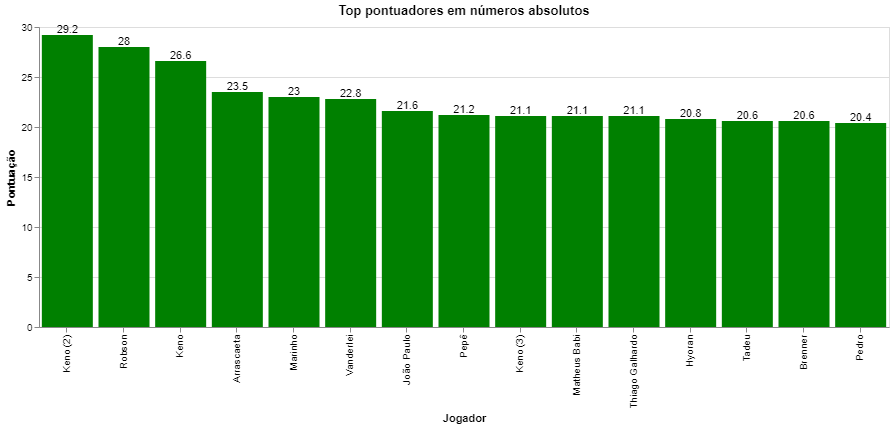

In [3]:
# O jogador Keno aparece 3x entre os jogadores com mais de vinte pontos
# Foi preciso adaptar seu nome para não ocorrerem sobreposições:
df_rodadas_tpa = df_rodadas[df_rodadas.Pontuação > 20]
pd.options.mode.chained_assignment = None
df_rodadas_tpa.loc[8286, 'Jogador'] = 'Keno (2)'
df_rodadas_tpa.loc[10327, 'Jogador'] = 'Keno (3)'

# Gráfico com os top pontuadores em números absolutos:
grafico_tpa = alt.Chart(df_rodadas_tpa).mark_bar().encode(
    x = alt.X('Jogador:N',
        sort = alt.EncodingSortField(
            field = 'Pontuação',
            order = 'descending'
        )
    ),
    y = alt.Y('Pontuação', scale=alt.Scale(domain = (0, 30))),
    color = alt.value('Green'),
    tooltip = ['Clube', 'Posição', 'Rodada', 'Variação (C$)']
).properties(
    width = 850,
    height = 300,
    title = 'Top pontuadores em números absolutos'
    )

# Texto com a pontuação dos jogadores nas rodadas que foram destaque:
text_tpa = grafico_tpa.mark_text(align = 'center', baseline = 'bottom').encode(
    text = 'Pontuação',
    color = alt.value('Black')
    )

# Plotando gráfico com o texto:
grafico_tpa + text_tpa

$\hspace{10mm}$ No intuito de construir um heatmap com os maiores pontuadores em média, filtrou-se os dados com base na média da última rodada, 23.

In [4]:
# Filtrando apenas pontuações da rodada 23:
df_rodada_23 = df_rodadas[df_rodadas['Rodada'] == 23]

# Filtrando apenas os dez melhores pontuadores pela média dos pontos das partidas disputadas:
df_rodada_23_top10 = df_rodada_23.sort_values(by = 'Média', ascending = False).head(10)

# Colocando o nome completo dos dez melhores em uma lista:
lista_top10 = list(df_rodada_23_top10['Nome completo'])

# Selecionando nos dados com todas as rodadas apenas os jogadores da lista anterior:
df_top10 = df_rodadas[df_rodadas['Nome completo'].isin(lista_top10)].reset_index(drop = True)

# Criando uma coluna que ranqueia esses jogadores para auxiliar no ajuste do gráfico:
df_top10.loc[0:209,'Rank_10'] = df_top10.Média[df_top10['Rodada'] == 23].rank(ascending = False)

$\hspace{10mm}$ O resultado final foi o heatmap abaixo.

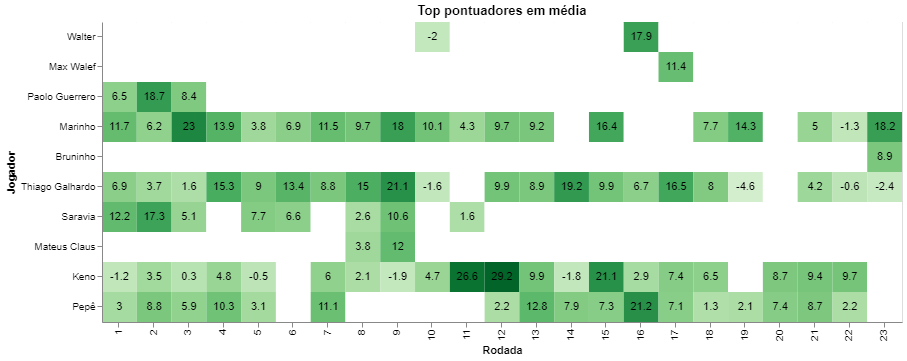

In [5]:
# Gráfico com os top pontuadores em média:
grafico_tpm = alt.Chart(df_top10).mark_rect().encode(
    x = 'Rodada:N',
    y = alt.Y('Jogador:N',
        sort = alt.EncodingSortField(
            field = 'Rank_10',
            order = 'ascending'
        )
    ),
    color=alt.condition(
    alt.datum.Pontuação != 0,
    alt.Color('Pontuação:Q', legend = None, scale = alt.Scale(scheme = 'Greens')),
    alt.value('White')),
    tooltip = ['Média']
).properties(
    width = 800,
    height = 300,
    title = 'Top pontuadores em média'
)

# Texto com a pontuação dos jogadores em cada rodada:
text_tpm = grafico_tpm.mark_text(baseline = 'middle').encode(
    text = 'Pontuação:Q',
    color = alt.condition(
        alt.datum.Pontuação != 0,
        alt.value('Black'),
        alt.value('White'))
)

# Plotando gráfico mais texto sobre o gráfico:
grafico_tpm + text_tpm

$\hspace{10mm}$ Nota-se a presença de alguns jogadores que jogaram apenas algumas partidas e se afastaram dos gramados com pontuações elevadas. Por exemplo, os jogadores Paolo Guerrero com três jogos e Max Walef com somente um. Para corrigir esse problema, filtrou-se, apenas, os jogadores com pelo menos dez jogos.

In [6]:
# Filtrando pontuações da rodada 23 de jogadores com pelo menos dez jogos:
df_rodada_23_10J = df_rodada_23[df_rodada_23['Jogos'] > 9]

# Filtrando apenas os dez melhores pontuadores com pelo menos dez jogos pela média dos pontos das partidas disputadas:
df_rodada_23_10J_top10 = df_rodada_23_10J.sort_values(by = 'Média', ascending = False).head(10)

# Colocando o nome completo dos dez melhores com pelo menos dez jogos em uma lista:
lista_top10_10J = list(df_rodada_23_10J_top10['Nome completo'])

# Selecionando nos dados com todas as rodadas apenas os jogadores da lista anterior:
df_top10_10J = df_rodadas[df_rodadas['Nome completo'].isin(lista_top10_10J)].reset_index(drop=True)

# Criando uma coluna que ranqueia esses jogadores para auxiliar no ajuste do gráfico:
df_top10_10J.loc[0:229,'Rank_10'] = df_top10_10J.Média[df_top10_10J['Rodada'] == 23].rank(ascending=False)

$\hspace{10mm}$ Diante disso, encontrou-se um gráfico mais homogêneo em participações. Destacam-se os desempenhos dos jogadores Marinho que jogou dezenove partidas e mantém uma média de $10,44$ pontos e Thiago Galhardo que não jogou apenas dois jogos com $8,05$ pontos.

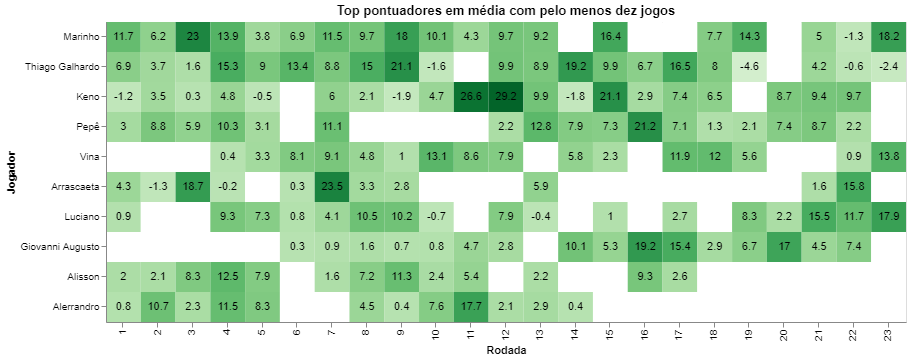

In [7]:
# Gráfico dos top pontuadores em média com pelo menos dez jogos:
grafico_tpm10 = alt.Chart(df_top10_10J).mark_rect().encode(
    x = 'Rodada:N',
    y  = alt.Y('Jogador:N',
        sort = alt.EncodingSortField(
            field = 'Rank_10',
            order = "ascending"
        )
    ),
    color = alt.condition(
    alt.datum.Pontuação != 0,
    alt.Color('Pontuação:Q', legend = None, scale = alt.Scale(scheme='Greens')),
    alt.value('White')),
    tooltip = ['Média']
).properties(
    width=800,
    height=300,
    title='Top pontuadores em média com pelo menos dez jogos'
)

# Texto sobre o heatmap:
text_tpm10 = grafico_tpm10.mark_text(baseline='middle').encode(
    text='Pontuação:Q',
    color=alt.condition(
        alt.datum.Pontuação != 0,
        alt.value('Black'),
        alt.value('White'))
)

# Plotando gráfico com o texto:
grafico_tpm10 + text_tpm10

$\hspace{10mm}$ Ilustrou-se os principais jogadores em cada um dos principais scouts: defesas difíceis e gols sofridos para goleiros, gols e assistências e, por último, os três tipos de finalizações que não resultam em gol, para fora, defendidas e na trave. Todos os gráficos foram gerados com o auxílio da função genérica abaixo.

In [8]:
# Função para construção dos gráficos de scouts:
def grafico_scouts(scouts, j, domain_max, title, w, h):    
    # Entradas: scouts, corte para o scout, range máximo do eixo y, título, largura e altura do gráfico.
    
    # Gráfico:
    base = alt.Chart(df_rodada_23[df_rodada_23[scouts] > j]).mark_bar().encode(
        x = alt.X("Jogador:N",
            sort = alt.EncodingSortField(
                field = scouts,
                order = "descending"
            )
        ),
        y = alt.Y(scouts, scale=alt.Scale(domain = (0, domain_max))),
        color = alt.value('Green')
    ).properties(
        width = w,
        height = h,
        title = title
    )
    
    # Texto:
    text = base.mark_text(align = "center", baseline = "bottom").encode(
        text = scouts,
        color = alt.value('Black')
    )
    
    # Gráfico + texto:
    return base + text

$\hspace{10mm}$ Verificou-se, assim, o resultado dos principais scouts para os goleiros. Defesas difíceis somam quatro pontos e gols sofridos subtraem dois pontos. Fernando Prass do Ceará é referência neste ano em defesas difíceis, com $28$ defesas complicadas. Por outro lado, é, também, o goleiro com o maior número de gols sofridos, são $32$.

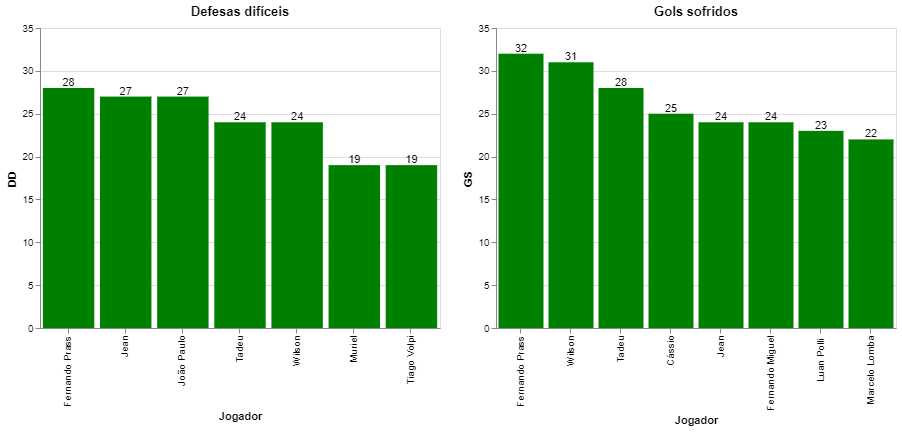

In [9]:
grafico_scouts('DD', 18, 35, 'Defesas difíceis', 400, 300) | grafico_scouts('GS', 21, 35, 'Gols sofridos', 400, 300)

$\hspace{10mm}$ Na sequência, viu-se os principais goleadores e os principais jogadores que dão assistências para gols. O artilheiro até o momento é o Thiago Galhardo, com $15$ gols, do Internacional, seguido por Marinho, com $13$ gols, do Santos. Ademais, Marinho é o destaque em colocar os companheiros em condições de finalização com $6$ assistências.

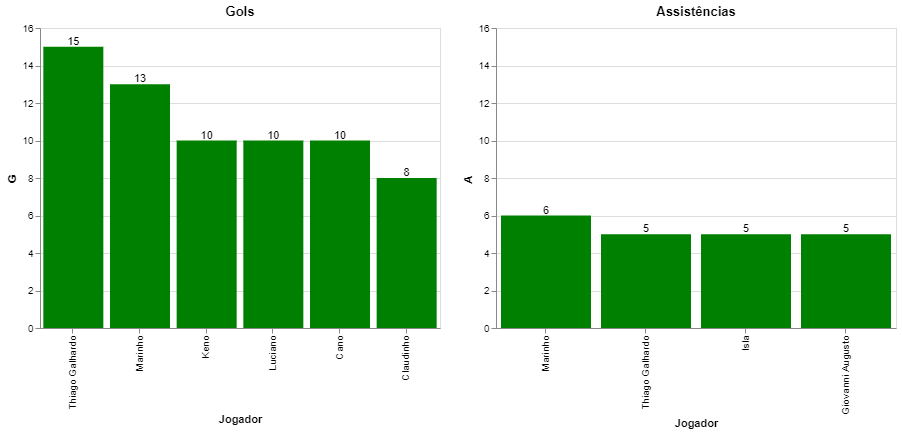

In [10]:
grafico_scouts('G', 7, 16, 'Gols', 400, 300) | grafico_scouts('A', 4, 16, 'Assistências', 400, 300)

$\hspace{10mm}$ E, então, abaixo estão os jogadores que mais finalizam para fora, para defesa dos goleiros e, talvez a mais angustiante, na trave. Esta é destaque para Keno e Robson, que já acertaram $4$ vezes na trave.

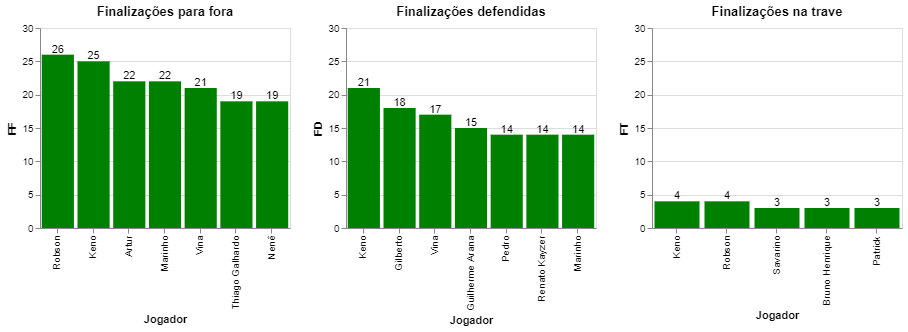

In [11]:
grafico_scouts('FF', 17, 30, 'Finalizações para fora', 250, 200) | grafico_scouts('FD', 13, 30, 'Finalizações defendidas', 250, 200) | grafico_scouts('FT', 2, 30, 'Finalizações na trave', 250, 200)

$\hspace{10mm}$ Prosseguiu-se com a análise eliminando os técnicos, para que seja possível reproduzir as estimativas com o modelo apenas com base nos jogadores, e adicionando o mando de campo para os clubes, este será usado para calcular qual a parcela de pontos feitos dentro e fora de casa e contribuirá, também, na modelagem.

In [12]:
# Eliminando técnicos dos dados:
df_ativos = df_rodadas[df_rodadas['Posição'] != 'TEC']

# Adicionando mando de campo:
df_ativos = df_ativos.reset_index(drop = True)

df_ativos['Campo'] = 0

for i in range(0, df_ativos.shape[0]):
    if df_jogos[(df_jogos['Rodada'] == df_ativos.loc[i, 'Rodada']) & (df_jogos['Casa'] == df_ativos.loc[i, 'Clube'])].empty == False:
        df_ativos.loc[i, 'Campo'] = 'C'
    else:
        df_ativos.loc[i, 'Campo'] = 'F'  

$\hspace{10mm}$ Assim, foi possível calcular a quantidade de pontos feitos dentro e fora de casa. A soma dos pontos realizados pelos jogadores de times mandantes foi de $8466,6$ e representa $54,57\%$ da pontuação total contra $7048,4$ pontos feitos pelos jogadores visitantes.

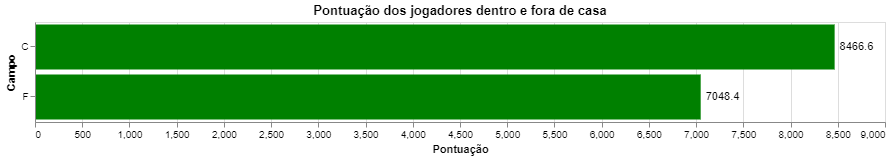

In [13]:
# Somando pontuação para jogos em casa e fora:
df_mando = df_ativos[['Pontuação', 'Campo']].groupby('Campo').sum().reset_index()

# Contrução do gráfico de barras com os dados:
grafico_cf = alt.Chart(df_mando).mark_bar().encode(
    y = 'Campo:N',
    x = 'Pontuação',
    color = alt.value('Green')
).properties(
    width = 850,
    height = 100,
    title = 'Pontuação dos jogadores dentro e fora de casa'
)

# Texto:
text_cf = grafico_cf.mark_text(align = "left", baseline = "middle", dx=5).encode(
    text = 'Pontuação',
    color = alt.value('Black')
)
    
# Gráfico + texto:
grafico_cf + text_cf

$\hspace{10mm}$ Além disso, calculou-se a média de cada posição dos jogadores. Os laterais lideram com média de $2,93$ seguidos pelos atacantes com $2,84$ pontos. Por últimos estão os goleiros com $2,11$ de pontuação média.

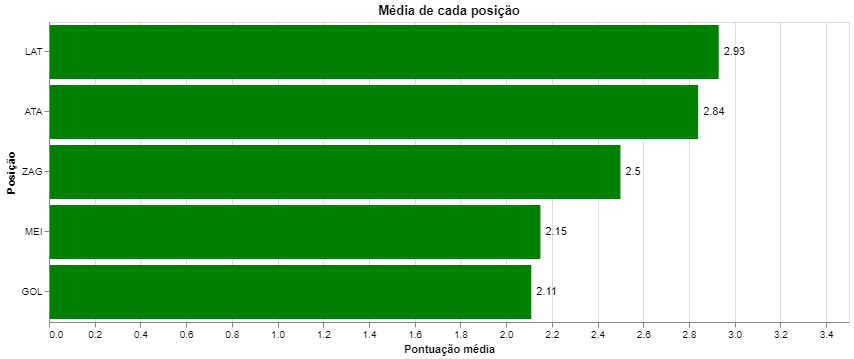

In [14]:
# Calculando média de cada posição dos jogadores ativos:
df_med_pos = df_ativos[df_ativos['Pontuação'] != 0][['Pontuação', 'Posição']].groupby('Posição').mean().reset_index()

# Limitando quantidade de casas decimais das médias:
df_med_pos['Pontuação média'] = round(df_med_pos['Pontuação'], 2)

# Gráfico com as médias:
grafico_mp = alt.Chart(df_med_pos).mark_bar().encode(
    y  = alt.Y('Posição:N',
        sort = alt.EncodingSortField(
            field = 'Pontuação média',
            order = "descending"
        )
    ),    
    x = alt.X('Pontuação média', scale=alt.Scale(domain = (0, 3.5))),
    color = alt.value('Green')
).properties(
    width = 800,
    height = 300,
    title = 'Média de cada posição'
)

# Texto:
text_mp = grafico_mp.mark_text(align = "left", baseline = "middle", dx=5).encode(
    text = 'Pontuação média',
    color = alt.value('Black')
)

# Plotando gráfico com o texto:
grafico_mp + text_mp

### Modelo de predição

$\hspace{10mm}$ Primeiramente, separou-se os dados a partir da quinta rodada e adicionou-se os dados da pontuação em $t+1$ chamando a nova coluna de $(Output)$, pois utilizará-se os dados históricos de cada rodada para prever a pontuação dos jogadores na rodada seguinte.

In [15]:
# Selecionando dados a partir da quinta rodada:
df_ativos_5 = df_ativos[df_ativos['Rodada'] > 4].reset_index(drop = True)

# Criando coluna de output, ou seja, pontuação em t+1:
df_ativos_5['Output'] = 0

for i in range(0, df_ativos_5.shape[0]):
    if df_ativos_5.loc[i, 'Rodada'] < 23:
        row = df_ativos_5[(df_ativos_5['Nome completo'] == df_ativos_5.loc[i, 'Nome completo']) & (df_ativos_5['Rodada'] == df_ativos_5.loc[i, 'Rodada'] + 1)]
        if row.empty == False:                                         
            df_ativos_5.loc[i, 'Output'] =  float(row['Pontuação'])

$\hspace{10mm}$ Agrupou-se, também, quem é o próximo rival e qual é o mando de campo do jogo seguinte.

In [16]:
# Adicionando clube rival:
df_ativos_5['Próximo rival'] = 0
df_ativos_5['Próximo campo'] = 0

for i in range (0, df_ativos_5.shape[0]):
    
    # Recortando dados da rodada seguinte:
    jogos_rodada = df_jogos[df_jogos['Rodada'] == df_ativos_5.loc[i, 'Rodada'] + 1]
    
    if jogos_rodada[jogos_rodada['Casa'] == df_ativos_5.loc[i, 'Clube']].empty == False:
        # Próximo rival quando o time jogará em casa:
        df_ativos_5.loc[i, 'Próximo rival'] = jogos_rodada[jogos_rodada['Casa'] == df_ativos_5.loc[i, 'Clube']]['Fora'].to_string(index=False)
        # 0 representa jogar fora de casa e 1 jogar dentro de casa, abaixo alternou-se de 0 para 1 para os próximos jogos fora:
        df_ativos_5.loc[i, 'Próximo campo'] = 1
    else:
        # Próximo rival quando o time jogará em casa:
        df_ativos_5.loc[i, 'Próximo rival'] = jogos_rodada[jogos_rodada['Fora'] == df_ativos_5.loc[i, 'Clube']]['Casa'].to_string(index=False)
        
# Alterando tipo dos dados dos scouts para inteiros:
df_ativos_5.iloc[:,10:28] = df_ativos_5.iloc[:,10:28].astype(int)

$\hspace{10mm}$ Além dos dados reunidos até o momento, somou-se ao data frame os dados somados dos jogadores do time rival para cada jogador. 

In [17]:
# Data frame para salvar soma dos scouts dos clubes:
df_dados_rival = pd.DataFrame()

for i in range (0, df_ativos_5.shape[0]):
    
    # Soma dos dados históricos dos times naquela rodada:
    soma_clubes = df_ativos_5[df_ativos_5['Rodada'] == df_ativos_5.loc[i, 'Rodada']].groupby(['Clube']).sum().reset_index()
    # Selecionando dados do time rival:
    dados_rival = soma_clubes[soma_clubes['Clube'] == df_ativos_5.loc[i, 'Próximo rival'].strip()].iloc[:,4:22]
    # Reunindo dados:
    df_dados_rival = pd.concat([df_dados_rival, dados_rival])
    
# Adicionando "-R" aos nomes das colunas dos scouts dos dados rivais:
df_dados_rival.columns = [str(col) + '-R' for col in df_dados_rival.columns]

# Organizando dados e agrupando com os dados anteriores:
df_dados_rival = df_dados_rival.reset_index(drop=True)

df_modelo = pd.concat([df_ativos_5, df_dados_rival], axis = 1)

$\hspace{10mm}$ Com o data frame organizado, foi possível prosseguir para a construção do modelo de predição, no qual utilizou-se a biblioteca de machine learning Scikit-learn. Cada linha da tabela $df\_modelo$ representa as condições de um jogador em uma rodada e é composta pelos scouts históricos dele próprio e da soma dos scouts acumulados do próximo time a ser enfrentado. Além disso, há também quem é o mandante do próximo jogo.

$\hspace{10mm}$ A ideia do modelo consiste em separar os dados em passado e futuro - considerando a rodada fornecida para previsão, calcular quais são as variáveis mais significativas com o alvo, ou seja, a pontuação, agrupar as melhores variáveis em um conjunto que minimiza o erro absoluto médio e aplicar essas features em uma regressão linear múltipla. Para finalizar, em posse dos coeficientes, estimar as pontuações dos jogadores para rodada seguinte.

$\hspace{10mm}$ Tudo foi organizado dentro de uma única função com entradas: posição dos jogadores e rodada.

In [18]:
# Função para rodar o modelo, com posição do jogador e rodada:
def predcartola(posicao, rodada):
    
    # Como a previsão é feita usando os dados da rodada anterior, desconta-se um para ajustar a seleção dos dados:
    rodada -= 1

    # Seleção da posição dos jogadores:
    df2 = df_modelo[df_modelo['Posição'] == posicao]
    
    # Seleção dos principais scouts para posição gol/campo e número de scouts +1:
    if posicao == 'GOL':
        lista_scouts = ['DD','GS','FF-R','FS-R','G-R','CA-R','FC-R','DS-R','FD-R','A-R','Próximo campo']
        k_lim = 12
    else:
        lista_scouts = ['FF','FS','G','CA','FC','DS','FD','A','FF-R','FS-R','G-R','CA-R','FC-R','DS-R','DD-R','GS-R','FD-R','A-R','Próximo campo']
        k_lim = 20
        
    # Seleção dos dados de teste - os dados foram divididos entre passado e futuro:
    df_test = df2[df2['Rodada'] == rodada]
    X_test = df_test[lista_scouts]
    y_test = df_test['Output']
    
    # Seleção dos dados de treino
    df_train = df2[(df2['Output'] != 0) & (df2['Rodada'] < rodada)]
    X_train = df_train[lista_scouts]
    y_train = df_train['Output']
    
    # Criando lista vazia para salvar o valor de mae em cada situação de k do laço abaixo:
    lista_k = [ ]

    # Calculará-se o mae para cada valor de k (k variáveis mais significativas) a partir de um grupo mínimo de cinco variáveis:
    for k in range(5,k_lim):

        selector = SelectKBest(score_func = f_regression, k=k)
    
        X_train2 = selector.fit_transform(X_train, y_train)
        X_test2 = selector.transform(X_test)

        mdl = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42)
        mdl.fit(X_train2, y_train)

        p = mdl.predict(X_test2)
        score = mean_absolute_error(y_test, p)
        lista_k.append(score)

    # Selecionando as melhores variáveis que minimizam o mae conforme encontrado no laço acima:
    selector = SelectKBest(score_func = f_regression, k = lista_k.index(min(lista_k)) + 5)
    selector.fit(X_train, y_train)
    mask = selector.get_support()

    # Filtrando variáveis selecionadas acima:
    X_train2 = X_train.iloc[:,mask]
    X_test2 = X_test.iloc[:,mask]

    # Nova regressão com os dados de treino:
    regr = LinearRegression()
    regr.fit(X_train2, y_train)

    # Aplicando coeficientes aos dados futuros e separando os melhores jogadores da predição em um ranking:
    predict = regr.predict(X_test2)
    df_test = df_test.reset_index(drop=True)
    df_test['Predição'] = predict
    return(df_test.sort_values(by=['Predição'], ascending=False)[['Jogador', 'Clube', 'Próximo rival', 'Predição']].head())

$\hspace{10mm}$ Abaixo, pode-se verificar como foram as previsões para todas as posições na rodada 17.

In [19]:
# Previsão das pontuações de atacantes para rodada 17:
predcartola('ATA', 17)

,Jogador,Clube,Próximo rival,Predição
155,Marinho,Santos,Coritiba,10.976903
134,Keno,Atlético-MG,Bahia,8.561761
70,Gilberto,Bahia,Atlético-MG,6.760300
120,Pepê,Grêmio,São Paulo,6.649440
116,Robson,Coritiba,Santos,6.604484


In [20]:
# Previsão das pontuações de meias:
predcartola('MEI', 17)

,Jogador,Clube,Próximo rival,Predição
160,Thiago Galhardo,Internacional,Vasco,10.815392
229,Nenê,Fluminense,Ceará,6.883193
149,Alisson,Grêmio,São Paulo,6.857082
156,Vina,Ceará,Fluminense,5.960397
126,Fernando Sobral,Ceará,Fluminense,5.873033


In [21]:
# Previsão das pontuações de laterais:
predcartola('LAT', 17)

,Jogador,Clube,Próximo rival,Predição
84,Guilherme Arana,Atlético-MG,Bahia,6.251418
97,Reinaldo,São Paulo,Grêmio,4.616277
36,Nicolas,Atlético-GO,Athlético-PR,4.151412
5,Victor Luis,Botafogo,Goiás,3.962940
110,Madson,Santos,Coritiba,3.899875


In [22]:
# Previsão das pontuações de zagueiros:
predcartola('ZAG', 17)

,Jogador,Clube,Próximo rival,Predição
15,David Sousa,Botafogo,Goiás,3.339243
31,Wesley,Botafogo,Goiás,3.339243
32,Helerson,Botafogo,Goiás,3.339243
98,Fabrício Bruno,Bragantino,Sport,3.173917
95,Realpe,Bragantino,Sport,3.173917


In [23]:
# Previsão das pontuações de goleiros:
predcartola('GOL', 17)

,Jogador,Clube,Próximo rival,Predição
38,Diego Cavalieri,Botafogo,Goiás,2.861242
29,Cássio,Corinthians,Flamengo,2.836312
56,Cleiton,Bragantino,Sport,2.800041
34,Anderson,Bahia,Atlético-MG,2.786849
68,Tadeu,Goiás,Botafogo,2.411895


$\hspace{10mm}$ Escalou-se o time recomendado pelo script por sete rodadas (17-23). A escalação escolhida foi a mais comum entre os cartoleiros: 4-3-3. Em todas as rodadas, buscou-se escalar os mais bem colocados no modelo de predição e que constavam como prováveis. O técnico escolhido foi aquele do time com o maior número de representantes entre os jogadores escalados e, em caso de empate na quantidade de jogadores escalados, optou-se pelo técnico do clube dos jogadores com maior soma de pontos previstos. Vale destacar, ainda, que o capitão foi aquele com o maior número de pontos previstos. No caso da rodada 17, o time recomendado foi o seguinte:

<br/><br/>


| Posição | Jogador             | Clube         | Pontuação |
|---------|---------------------|---------------|-----------|
| GOL     | Diego Cavalieri     | Botafogo      | 8,6 pts   |
| ZAG     | Rafael Forster      | Botafogo      | 6,4 pts   |
| ZAG     | Marcelo Benevenuto  | Botafogo      | 4,4 pts   |
| LAT     | Guilherme Arana     | Atlético-MG   | 1,5 pts   |
| LAT     | Reinaldo            | São Paulo     | 5,5 pts   |
| MEI     | Thiago Galhardo (C) | Internacional | 16,5 pts  |
| MEI     | Nenê                | Fluminense    | -0,2 pts  |
| MEI     | Alisson             | Grêmio        | 2,6 pts   |
| ATA     | Keno                | Atlético-MG   | 7,4 pts   |
| ATA     | Gilberto            | Bahia         | 15,6 pts  |
| ATA     | Pepê                | Grêmio        | 7,1 pts   |
| TEC     | Bruno Lazaroni      | Botafogo      | 4,49 pts  |

<br/><br/>

$\hspace{10mm}$ Por fim, plotou-se os resultados da predição para as rodadas acompanhadas. Viu-se que o modelo foi capaz de superar a média dos cartoleiros em cinco das sete rodadas. A maior pontuação foi de $96,39$ e a pior de $34,96$ pontos.

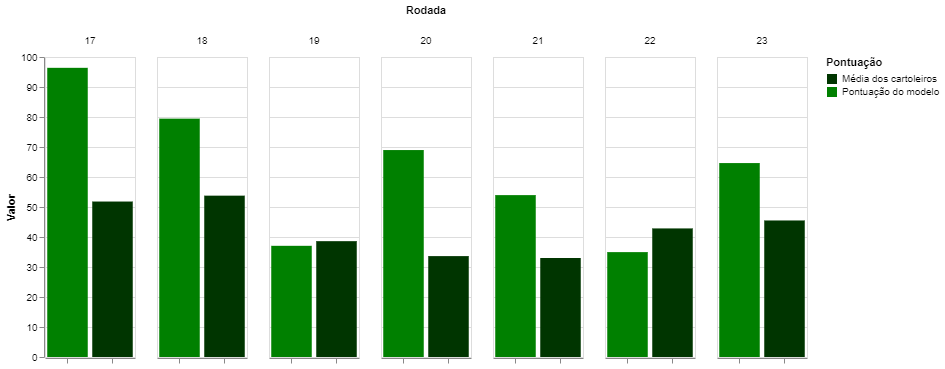

In [24]:
# Criando data frame com os dados do modelo e a média dos cartoleiros:
pred_results = {'Rodada': [17, 18, 19, 20, 21, 22, 23], 'Pontuação do modelo': [96.39, 79.45, 37.06, 68.98, 53.96, 34.96, 64.64], 'Média dos cartoleiros': [51.82, 53.78, 38.61, 33.63, 33, 42.86, 45.51]}
pred_results = pd.DataFrame(data = pred_results)

# Convertendo em três colunas para auxiliar plotagem:
pred_results = pred_results.melt('Rodada', var_name='Pontuação', value_name='Valor')

# Contrução gráfica da comparação:
alt.Chart(pred_results).mark_bar().encode(
    x = alt.X('Pontuação', axis=alt.Axis(title=None, labels=False), sort = alt.EncodingSortField(field = 'Pontuação', order = "ascending")),
    y = 'Valor',
    color=alt.Color('Pontuação',
                   scale=alt.Scale(
            domain=['Média dos cartoleiros', 'Pontuação do modelo'],
            range=['#003500', 'green'])),
    column = 'Rodada',
    tooltip = ['Valor']
).properties(
    width = 90,
    height = 300
    )

### Conclusões

$\hspace{10mm}$ Inicialmente, foi possível visualizar o desempenho dos jogadores que mais se destacaram no período abordado no game. Posteriormente, notou-se que os jogadores pontuam mais jogando em casa, mas a diferença não é muito grande. As posições que mais pontuaram foram laterais e atacantes. Finalizou-se com o relativo fracasso do script de predição, ele não foi capaz de superar a média dos cartoleiros em cada rodada como era esperado, mas fez uma média considerável nos sete jogos analisados: $62,2$ pontos.

### Referências

[1] H. Gomide e A. Gualberto, CaRtola: Extração de dados da API do CartolaFC, análise exploratória dos dados e modelos preditivos em R e Python. Disponível em: https://github.com/henriquepgomide/caRtola/. Acesso em setembro de 2020.

[2] Globo Esporte, Cartola FC. Disponível em: https://globoesporte.globo.com/cartola-fc/noticia/cartola-fc-2020-veja-as-pontuacoes-de-todos-os-scouts.ghtml. Acesso em setembro de 2020.

[3] SAKATA, André Guimarães. Aplicando Machine Learning no CartolaFC. Disponível em: https://medium.com/@andresakata/aplicando-machine-learning-no-cartolafc-4ebb5aa0a531. Acesso em outubro de 2020.